<a href="https://colab.research.google.com/github/kbyshiro/CMAPSS_tasks/blob/main/score_analysis_20201208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリのインポート


In [1]:
# Gitのクローン
!git clone  https://github.com/kbyshiro/CMAPSS_tasks.git "gitproject"

Cloning into 'gitproject'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [2]:
import os
import sys
sys.path.append('/content/gitproject/library/')
sys.path.append('/content/gitproject/model/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
sns.set()
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [3]:
from fd_dataset import FD_Dataset 
from models import LSTMRegressor

In [4]:
fd = FD_Dataset()
fd.load(data_id=1)
fd.MinMaxNorm()

# RULに制限を設ける。
# RUL_limit = 130
# fd.LimitRUL(RUL_limit=RUL_limit)

In [5]:
Y_max = max(fd.raw_train["Cycle"].max()-1, fd.raw_rul_test.iloc[-1].max())
print(Y_max)

361


#データローダーの準備

In [6]:
#tuning parameters
window_size = 30
batch_size = 100
cut_size = 10

In [7]:
train = fd.SlideWindow(fd.train, window_size, mode='LSTM')
test = fd.SlideWindow(fd.test, window_size,mode='LSTM')
dataloader = torch.utils.data.DataLoader(train, batch_size= batch_size)

In [8]:
# Unit毎のデータの用意
datasize = fd.raw_train.groupby("UnitNumber").size() - window_size
s, e = 0, 0
TrainPerUnit = []
for x in datasize:
    e += x
    TrainPerUnit.append((fd.train.X[s:e], fd.train.t[s:e]))
    s = e

datasize = fd.raw_test.groupby("UnitNumber").size() - window_size
s, e = 0, 0
TestPerUnit = []
for x in datasize:
    e += x
    TestPerUnit.append((fd.test.X[s:e], fd.test.t[s:e]))
    s = e

学習モデル

In [9]:
# model parameter
lstm_input_layer = 14
lstm_hidden_layer = 50
lstm_output_layer = 1

#訓練

In [10]:
# training epoches
n_epoches = 100
UnitSize = fd.raw_train["UnitNumber"].max()
print(UnitSize)

100


In [11]:
class SCORE(nn.Module):
  def __init__(self):
      super(SCORE, self).__init__()

  def coef(self, targets, Y_max):
    return targets/Y_max

  def Error1(self, inputs, targets):
    yr = inputs - targets
    ret = torch.Tensor([torch.exp(y/10)-1 if y >= 0 else torch.exp(-y/13)-1 for y in yr])
    return ret

  def Error2(self, inputs, targets):
    yr= inputs - targets
    ret = torch.Tensor([torch.exp(y/13)-1 if y >= 0 else torch.exp(-y/10)-1 for y in yr])
    return ret

  def forward(self, inputs, targets):
    cf = self.coef(targets, 100)
    loss = ((1-cf)*self.Error1(inputs, targets)+cf*self.Error2(inputs, targets)).sum()
    return loss

In [12]:
#training
model = LSTMRegressor(lstm_input_layer, lstm_hidden_layer, lstm_output_layer)
loss_fn = nn.MSELoss()
score_fn = SCORE()
optimizer = optim.Adam(model.parameters(), lr=.005)

# unit毎、EPOCH毎のLOSSの推移
UnitLoss = [[] for _ in range(UnitSize)] 

#training
for epoch in range(n_epoches):
    for i, data in enumerate(dataloader):
        x_batch, y_batch = data
        optimizer.zero_grad()
        model.init_hidden(len(x_batch))
        #calc 
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.view(-1), y_batch)
        # update
        loss.backward()
        optimizer.step()
      
    with torch.no_grad():
        for i, data in enumerate(TrainPerUnit):
            x = data[0]
            t = data[1]
            # print(x.size(), t.size())
            model.init_hidden(x.size(0))
            y_pred = model(x)
            rmse = torch.sqrt(loss_fn(y_pred.view(-1), t))
            score = score_fn(y_pred.view(-1), t)
            UnitLoss[i].append((y_pred, rmse, score))

    if epoch%10 == 9:
        eRMSE = sum([UnitLoss[i][epoch][1] for i in range(UnitSize)])
        eSCORE = sum([UnitLoss[i][epoch][2] for i in range(UnitSize)])
        print('epoch: {0:3}: RMSE: {1:10.8f}, \
          SCORE: {2:10.8f}'.format(epoch+1, eRMSE, eSCORE))
print('Done!')

epoch:  10: RMSE: 5630.74853516,           SCORE: 704887390208.00000000
epoch:  20: RMSE: 3332.74438477,           SCORE: 51444125696.00000000
epoch:  30: RMSE: 3429.12646484,           SCORE: 3059556608.00000000
epoch:  40: RMSE: 3493.09448242,           SCORE: 1911672192.00000000
epoch:  50: RMSE: 3344.33959961,           SCORE: 2013617152.00000000
epoch:  60: RMSE: 3330.26245117,           SCORE: 1260143104.00000000
epoch:  70: RMSE: 3275.51977539,           SCORE: 1068243584.00000000
epoch:  80: RMSE: 3146.81494141,           SCORE: 1835124608.00000000
epoch:  90: RMSE: 3147.12280273,           SCORE: 2004030848.00000000
epoch: 100: RMSE: 3194.57226562,           SCORE: 2071777664.00000000
Done!


In [13]:
y_true = test.t
with torch.no_grad():
    model.init_hidden(test.X.size(0))
    y_pred = model(test.X)
    loss_test = loss_fn(y_pred.view(-1), y_true)
    score_test = score_fn(y_pred.view(-1), y_true)
print('LOSS: {0}, SCORE: {1}'.format(np.sqrt(loss_test), score_test))

LOSS: 39.13447189331055, SCORE: 219141920.0


#結果の表示

In [14]:
f = plt.figure(figsize=(12, 5))
plt.plot(loss_his, label='LOSS')
plt.xlabel('epoch')
plt.ylabel('LOSS')
plt.ylim((-10, 100000))

NameError: ignored

<Figure size 864x360 with 0 Axes>

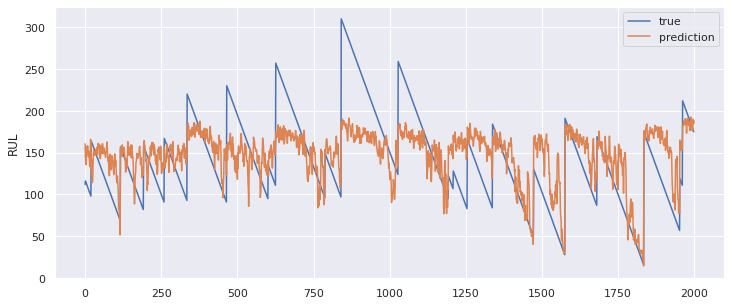

In [15]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[:2000], label='true')
plt.plot(y_pred[:2000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


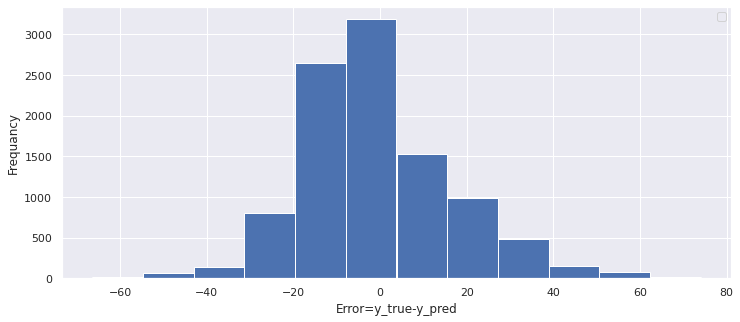

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.hist(y_pred.view(-1)-y_true,bins=12)
plt.xlabel('Error=y_pred-y_true')
plt.ylabel('Frequancy')
plt.legend()

Text(0, 0.5, 'Error')

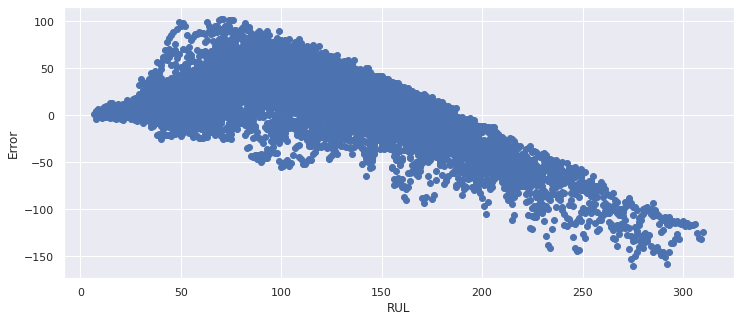

In [20]:
f= plt.figure(figsize=(12, 5))
plt.scatter(y_true, y_pred.view(-1)-y_true)
plt.xlabel("RUL")
plt.ylabel("Error")

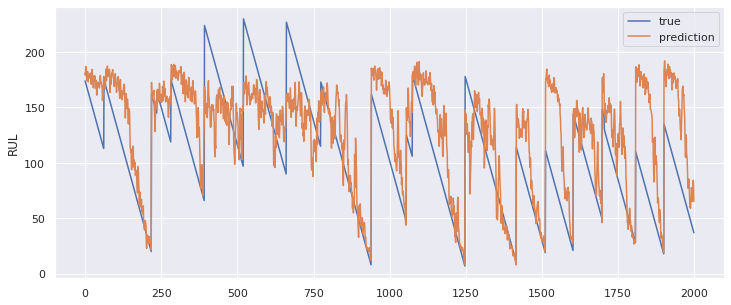

In [21]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[2000:4000], label='true')
plt.plot(y_pred[2000:4000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


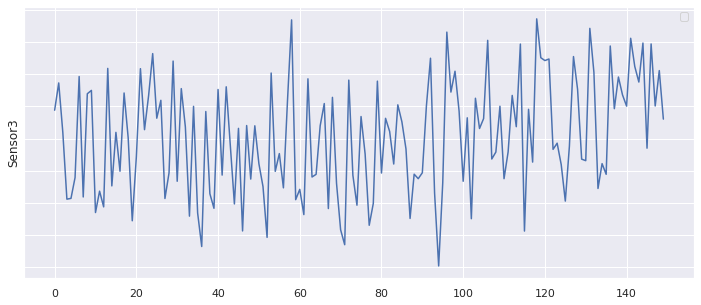

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.plot(fd.raw_train['Sensor_3'][:150])
plt.tick_params(labelleft=False)
plt.ylabel('Sensor3')
plt.legend()

In [32]:
TestUnitLog = [[] for _ in range (UnitSize)]
with torch.no_grad():
        for i, data in enumerate(TestPerUnit):
            x = data[0]
            t = data[1]
            # print(x.size(), t.size())
            model.init_hidden(x.size(0))
            y_pred_test = model(x)
            rmse = torch.sqrt(loss_fn(y_pred_test.view(-1), t))
            score = score_fn(y_pred_test.view(-1), t)
            TestUnitLog[i]=(y_pred_test, t,rmse, score)

Text(0, 0.5, 'SCORE')

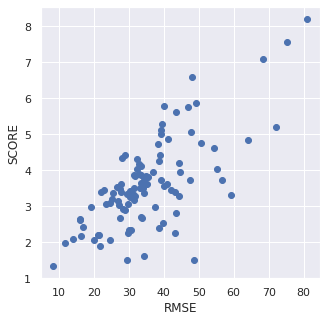

In [33]:
f = plt.figure(figsize=(5,5))
x=[TestUnitLog[i][2].item() for i in range(UnitSize)]
y=[np.log10(1+TestUnitLog[i][3].item())for i in range(UnitSize)]
plt.scatter(x, y)
plt.xlabel("RMSE")
plt.ylabel("SCORE")


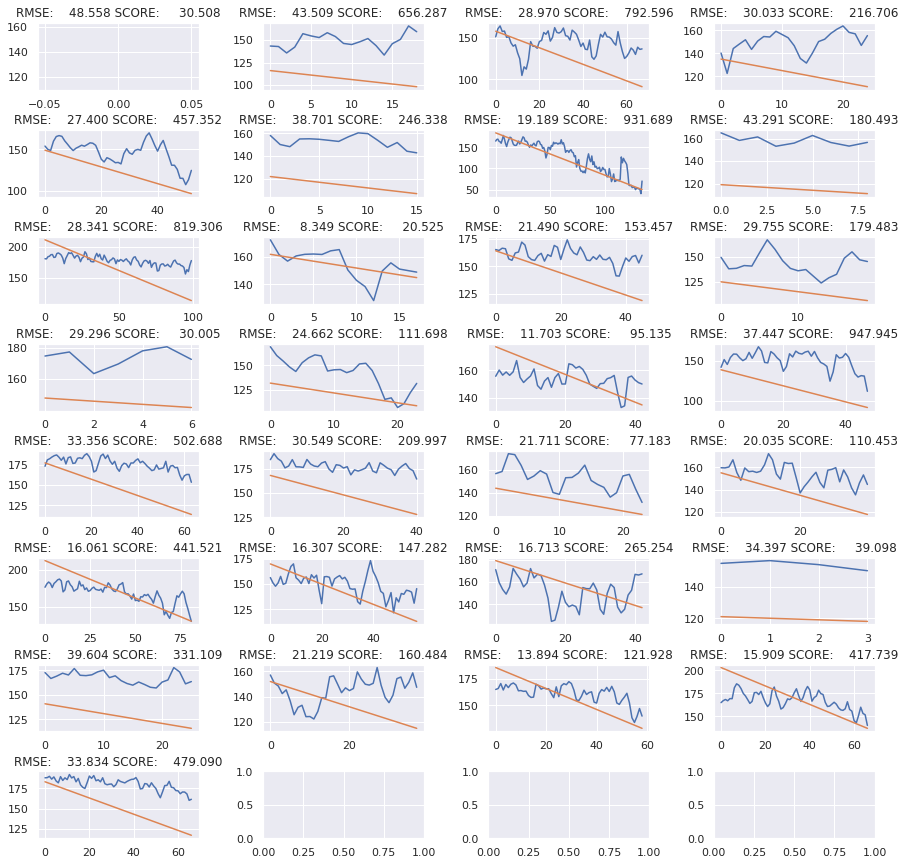

In [47]:
idx = [i for i in range(UnitSize) if 1 < np.log10(TestUnitLog[i][3]) <=3]
f, ax = plt.subplots(int((len(idx)+3)//4), 4, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for x, k in enumerate(idx):
  i = x//4
  j = x%4
  ax[i][j].plot(TestUnitLog[k][0])
  ax[i][j].plot(TestPerUnit[k][1])
  ax[i][j].set_title("RMSE:{0:10.3f} SCORE: {1:10.3f}".format(TestUnitLog[k][2], TestUnitLog[k][3]))

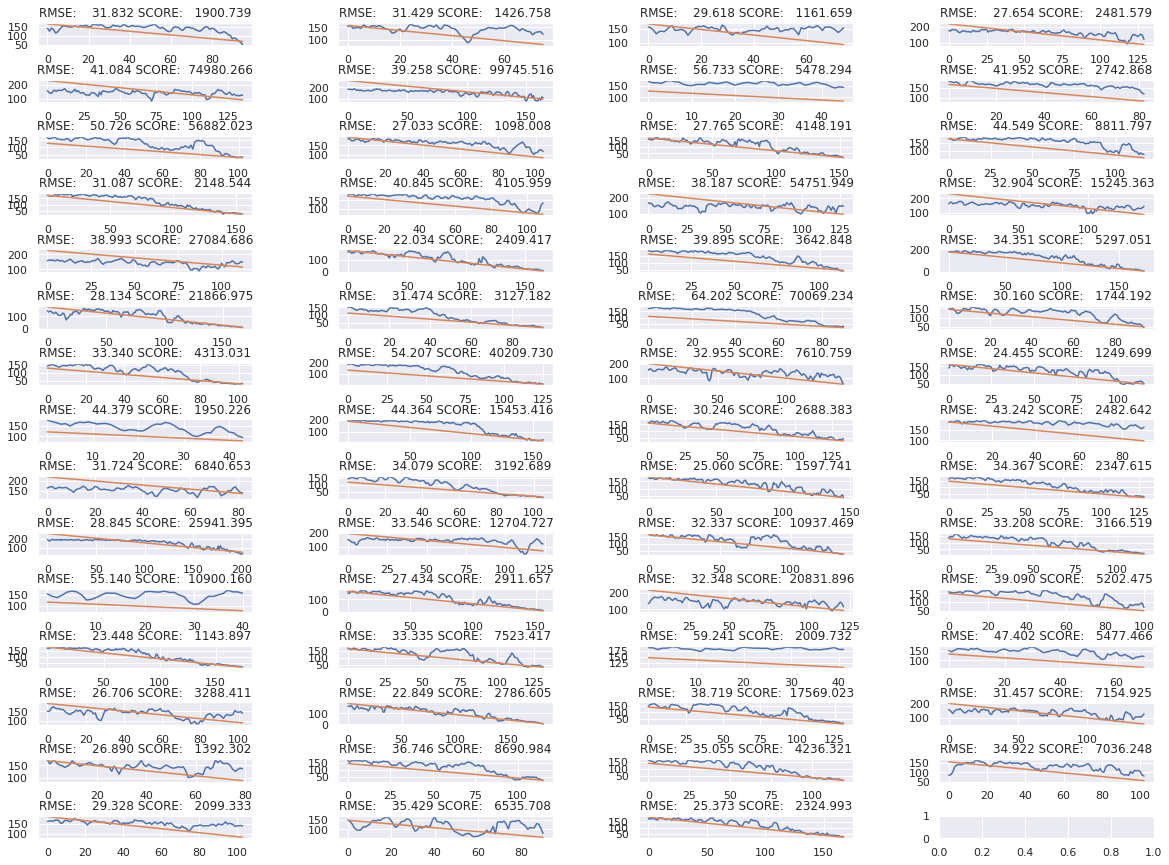

In [50]:
idx = [i for i in range(UnitSize) if 3 < np.log10(TestUnitLog[i][3]) <=5]
f, ax = plt.subplots(int((len(idx)+3)//4), 4, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4, hspace=1.5)
for x, k in enumerate(idx):
  i = x//4
  j = x%4
  ax[i][j].plot(TestUnitLog[k][0])
  ax[i][j].plot(TestPerUnit[k][1])
  ax[i][j].set_title("RMSE:{0:10.3f} SCORE: {1:10.3f}".format(TestUnitLog[k][2], TestUnitLog[k][3]))

# SCOREの設計

In [15]:
x= np.arange(-60, 60, 0.01)
y1= abs(x)
y2 = np.array([np.exp(y/10)-1 if y >= 0 else np.exp(-y/13)-1 for y in x])
y3 = np.array([np.exp(y/13)-1 if y >= 0 else np.exp(-y/10)-1 for y in x])

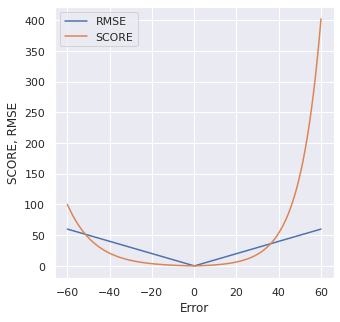

In [21]:
f = plt.figure(figsize = (5, 5))
plt.plot(x, y1, label='RMSE')
plt.plot(x,y2, label='SCORE')
plt.xlabel("Error")
plt.ylabel("SCORE, RMSE")
plt.legend()

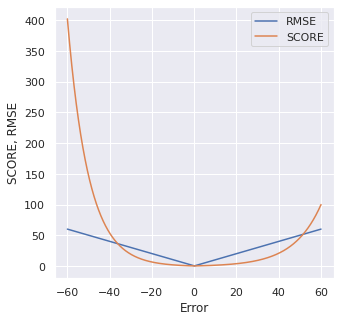

In [22]:
f = plt.figure(figsize = (5, 5))
plt.plot(x, y1, label='RMSE')
plt.plot(x,y3, label='SCORE')
plt.xlabel("Error")
plt.ylabel("SCORE, RMSE")
plt.legend()

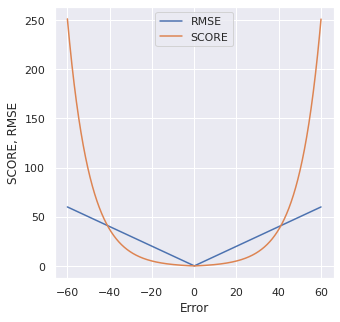

In [23]:
f = plt.figure(figsize = (5, 5))
plt.plot(x, y1, label='RMSE')
plt.plot(x,1/2*y2+1/2*y3, label='SCORE')
plt.xlabel("Error")
plt.ylabel("SCORE, RMSE")
plt.legend()

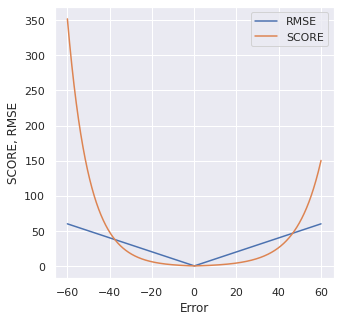

In [24]:
f = plt.figure(figsize = (5, 5))
plt.plot(x, y1, label='RMSE')
plt.plot(x,1/6*y2+5/6*y3, label='SCORE')
plt.xlabel("Error")
plt.ylabel("SCORE, RMSE")
plt.legend()

In [32]:
x = np.arange(0, 100, 0.1)
yt= torch.Tensor(100-x)
yh1= torch.Tensor([y-50 if 50 < y else y+10 for y in yt])
yh2= torch.Tensor([y+50 if 50 < y else y-10 for y in yt])
r1 =torch.sqrt(torch.sum((yh1-yt)*(yh1-yt)))
r2 =torch.sqrt(torch.sum((yh2-yt)*(yh2-yt)))
print(r1, r2)

tensor(1140.1754) tensor(1140.1754)


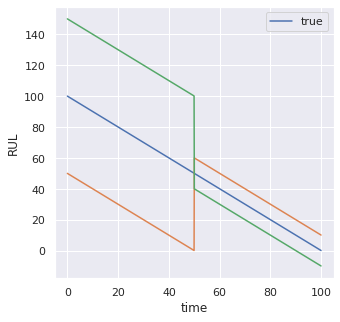

In [36]:
f = plt.figure(figsize = (5, 5))
plt.plot(x, yt, label='true')
plt.plot(x,yh1)
plt.plot(x,yh2)
plt.xlabel("time")
plt.ylabel("RUL")
plt.legend()

In [35]:
s = SCORE()
s1 = s(yh1, yt)
s2 = s(yh2, yt)
print(s1, s2)

tensor(61820.8984) tensor(36230.2109)
